In [19]:
%matplotlib inline
from scipy import optimize
import scipy
import numpy as np
import matplotlib.pyplot as plt
import time
inf = np.inf
plt.rcParams['figure.figsize'] = 12, 5

### Newton's Method for finding roots

(ref. Nocedal and Wright, _Numerical Optimization_)

We wish to find the roots of a vector-valued vector function $F(\vec x)$ ie. to solve

$$F(\vec x) = \vec 0$$.

We will approximate $F$ with a linear function $G_x(\vec p)$ centered at $\vec x$ where $\vec p$ is the vector of deviations from $\vec x$ (dropping arrows from here on):

$$G_x(p) = F(x) + J(x) p$$

where $J$ is the Jacobian matrix of $F$.

Newton's method is to find the $\vec 0$ of this linear approximation instead. That is, we seek a $p$ such that

$$
G_x(p) = 0 \\
= F(x) + J(x) p \\
\Rightarrow J(x)p = -F(x)
$$

Solving this linear system for the update $p$ gives us the value of $x$ for the next iteration:

$$x_{k+1} = x_k + p$$

In [374]:
def Newton_root(f, Jac, initial, eps=1e-8, maxit=1000,verbose=False):
    x_k = np.copy(initial)
    for it in xrange(maxit):
        f_k = f(x_k)
        J = Jac(x_k)
        p = np.linalg.solve(J, -f_k)
        if np.linalg.norm(p, ord=inf) < eps:
            break
        x_k = x_k + p
    if verbose:
        print "Iterations:",it
    return x_k

In [21]:
def FJ_for_sqrt(n):
    def func(x):
        return x*x - n
    def Jfunc(x):
        return 2*x
    return func,Jfunc
f,j = FJ_for_sqrt(2)

In [22]:
Newton_root(f, j, np.array([[2]]))

array([[ 1.41421356]])

### System of equations

Above, we found the square root of 2 by solving

$$x^2 - 2 = 0.$$
But Newton's method works for a system of equations too. Let's try to find the intersection point of a circle and a line. First let's draw it.

(-1.1, 1.1)

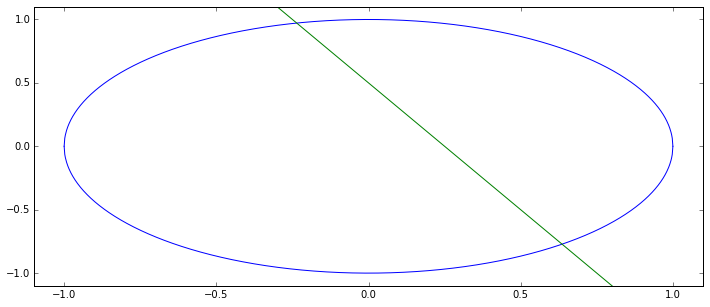

In [23]:
xs = np.linspace(-1,1,1000)
ycircP = np.sqrt(1-xs**2)
xline = np.linspace(-3,3,3000)
yline = 0.5 - 2*xline
plt.plot(xs, ycircP,color='blue')
plt.plot(xs, -ycircP,color='blue')
plt.plot(xline , yline,color='green')
plt.xlim(-1.1,1.1)
plt.ylim(-1.1,1.1)

We seek solutions to the system

$$ x^2 + y^2 - 1 = 0 \\
2x + y - 0.5 = 0$$

The Jacobian of this system is easy to write down:

$$ J(x,y) = \begin{bmatrix} 2x & 2y \\ 2 & 1 \end{bmatrix} $$

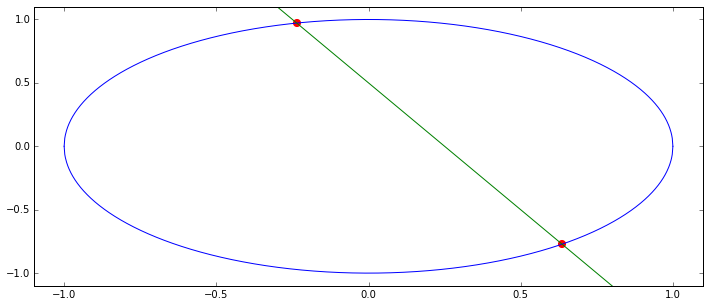

In [24]:
def f_circline(xvec):
    x,y = xvec[0],xvec[1]
    return np.array([x**2 + y**2 - 1, 2*x+y-0.5])
def J_circline(xvec):
    x,y = xvec[0],xvec[1]
    return np.array([[2*x, 2*y], [2,1]])
sol1 = Newton_root(f_circline,J_circline, np.array([0.1,0.00001]))
sol2 = Newton_root(f_circline,J_circline, np.array([-0.5,0.00001]))
xs = np.linspace(-1,1,1000)
ycircP = np.sqrt(1-xs**2)
xline = np.linspace(-3,3,3000)
yline = 0.5 - 2*xline
plt.plot(xs, ycircP,color='blue')
plt.plot(xs, -ycircP,color='blue')
plt.plot(xline, yline,color='green')
plt.xlim(-1.1,1.1)
plt.ylim(-1.1,1.1)
plt.scatter(sol1[0], sol1[1], s=50, color='red')
plt.scatter(sol2[0], sol2[1], s=50, color='red')

Notice that we get two different solutions depending on the initial point we start the Newton root-finding algorithm from. This is a feature common to many optimization techniques.

In fact, first-order methods cannot distinguish between maxima, minima and saddle points.

### Lagrange variables

Why would we want to solve systems of nonlinear equations? Suppose we have an optimization problem subject to some equality constraints:

$$\begin{equation*}
\begin{aligned}
& \underset{x}{\text{minimize}}
& & f(x) \\
& \text{subject to}
& & g_i(x) = b_i, \; i = 1, \ldots, m 
\end{aligned}
\end{equation*}
$$

This is a generalization of the unconstrained optimization problem, which can be solved by setting the gradient of $f$ to $0$ and solving for $x$:

$$\nabla f(x) = 0$$

For the constrained case, the gradient of $f$ is not $0$ but rather parallel to the constraints. This condition can be represented mathematically by introducing a scalar $\lambda_i$ for each constraint $g_i$ which is the amount by which you have to scale the gradients to get them to all equal each other.

This is equivalent to finding stationary points of the Lagrangian

$$\mathcal{L}(\vec x, \vec \lambda) = f(x) - \lambda^T (Ax-b)$$

ie. solving the system of equations

$$\frac{\delta \mathcal{L}}{\delta x_i} = 0 \\
 \frac{\delta \mathcal{L}}{\delta \lambda_i} = 0 $$
 
Note that in general neither the objective function nor the constraints have to be linear, so the system of equations above is nonlinear.
 
Let's try a simple example. We wish to find the point on the unit circle that minimizes the quantity $x+2y$. This can be written as

$$\begin{equation*}
\begin{aligned}
& \underset{x}{\text{minimize}}
& & x+2y \\
& \text{subject to}
& & x^2+y^2=1 \;
\end{aligned}
\end{equation*}$$

The Lagrangian for this problem is 

$$\mathcal{L}(x,y,\lambda) = x+2y - \lambda(x^2 + y^2 - 1)$$

so the system of equations we need to solve is

$$
\frac{\delta \mathcal{L}}{\delta x} = 1-2x \lambda = 0 \\
\frac{\delta \mathcal{L}}{\delta y} = 2-2y \lambda = 0 \\
\frac{\delta \mathcal{L}}{\delta \lambda} = x^2 + y^2 -1 = 0 
$$

Note that taking the derivative of $\mathcal{L}$ with respect to $\lambda$ simply recovers the constraint. 

Okay, in order to use Newton's Method to solve this system we have to take derivatives again. Fortunately the Jacobian of this system is pretty easy to write down:

$$ J(x,y,\lambda) = 
\begin{bmatrix} 
-2\lambda & 0 & -2x \\ 
0 & -2\lambda & -2y  \\
2x & 2y & 0
\end{bmatrix} $$

Phew! Now we can program it.

In [25]:
def f_circlemax(xs):
    xx,yy,ll = xs
    answer = np.zeros(3)
    answer[0] = 1 - 2*xx*ll
    answer[1] = 2 - 2*yy*ll
    answer[2] = xx**2 + yy**2 - 1
    #print answer
    return answer
def J_circlemax(xs):
    xx,yy,ll = xs
    answer = np.zeros((3,3))
    answer[0,0] = -2*ll
    answer[0,2] = -2*xx
    answer[1,1] = -2*ll
    answer[1,2] = -2*yy
    answer[2,0] = 2*xx
    answer[2,1] = 2*yy
    #print answer
    return answer
sol1_circlemax = Newton_root(f_circlemax, J_circlemax, np.array([-1,-2,3])) # optimize.slsqp.approx_jacobian

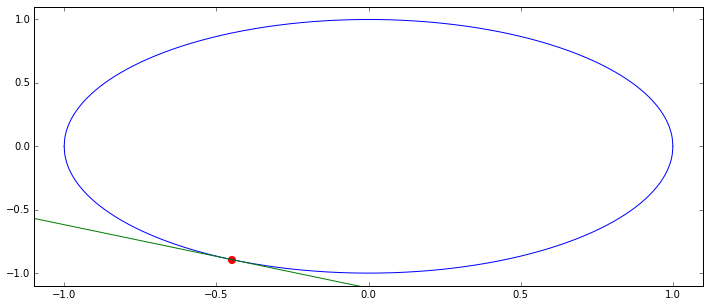

In [26]:
xs = np.linspace(-1,1,1000)
ycircP = np.sqrt(1-xs**2)
xline = np.linspace(-3,3,3000)
K = sol1_circlemax[0] + 2*sol1_circlemax[1]
yline = K/2 - xline/2
plt.plot(xs, ycircP,color='blue')
plt.plot(xs, -ycircP,color='blue')
plt.plot(xline, yline,color='green')
plt.xlim(-1.1,1.1)
plt.ylim(-1.1,1.1)
plt.scatter(sol1_circlemax[0], sol1_circlemax[1], s=50, color='red')

### Inequality constraints

Things get much more complicated when our problems contain inequality constraints. Consider this simple linear programming problem:

$$\begin{equation*}
\begin{aligned}
& \underset{x}{\text{minimize}}
& & 2x+y \\
& \text{subject to}
& & x+y \leq 1 \\
& & & x \geq 0 \\
& & & y \geq 0 \\
\end{aligned}
\end{equation*}
$$

That is, we wish to find the minimum value of $2x+y$ that lies within the shaded region shown below. To put this problem in standard form, we introduce a _slack variable_ $t$ which is the difference between $1$ and $x+y$. This difference must be positive, so $t = 1-x-y \geq 0$. Our problem becomes

$$\begin{equation*}
\begin{aligned}
& \underset{x}{\text{minimize}}
& & 2x+y \\
& \text{subject to}
& & x+y+t = 1 \\
& & & x \geq 0 \\
& & & y \geq 0 \\
& & & t \geq 0 
\end{aligned}
\end{equation*}
$$

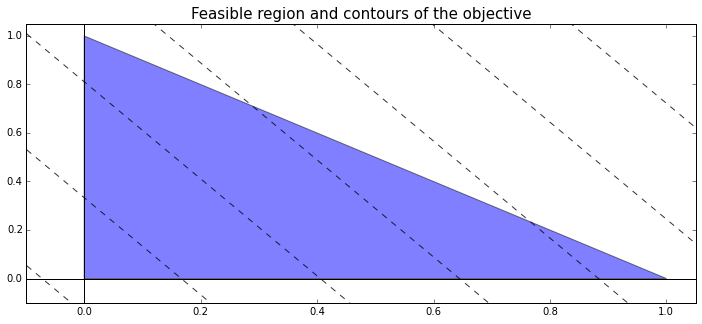

In [27]:
def draw_LP_region():
    xs = np.linspace(0, 1)
    ys = 1- xs
    plt.fill_between(xs, 0, ys, alpha=0.5)
    plt.axhline(0,color='k')
    plt.axvline(0,color='k')
    plt.xlim(-0.1,1.05)
    plt.ylim(-0.1,1.05)
    xs = np.linspace(-0.5, 1.5)
    for constant in np.linspace(-1.1, 3.2, 10):
        plt.plot(xs, constant-2*xs, 'k--', alpha=0.8) 
    plt.title("Feasible region and contours of the objective", size=15)
draw_LP_region()

Recall that for every equality constraint we introduced a Lagrange multiplier $\lambda$ and found stationary points of the Lagrangian 

$$\mathcal{L}(x,\lambda) = f(x) - \sum_\text{constraints}\lambda_i g_i(x)$$

With inequality constraints we again introduce multipliers $\mu$, but now the $\mu$ have to be positive. In addition, there is a nonlinear constraint relating the $\mu_i$ and their corresponding $x_i$:

$$ \mu_i x_i = 0. $$

This condition is known as _complementary slackness_: at the optimal, either a constraint is tight or its corresponding multiplier is 0.

It sounds like we have replaced _one_ inequality constraint with _two_, so what did we accomplish? Well, we have replaced a constrained optimization problem with a constrained root-finding problem, to which we can apply Newton steps. That part is relatively simple; all the complication will come from how we deal with the constraints.

The Lagrangian for our problem is

$$
\mathcal{L}(x_1,x_2,x_3,\lambda,\vec \mu) = 2x_1+x_2 - \lambda(x_1+x_2+x_3-1) - \mu_1 x_1 - \mu_2 x_2 - \mu_3 x_3 \\
$$

So our problem has been transformed to

$$\begin{equation*}
\begin{aligned}
& & & \frac{\delta \mathcal{L}}{\delta x_i} = 0 \\ 
& & & \mu_i x_i = 0 \\
& & & \sum_i x_i = 1 \\
& \text{subject to} \\
& & & x_i \geq 0 \\
& & & \mu_i \geq 0 \\
\end{aligned}
\end{equation*}
$$

where $x_i$ is understood to range over $x$, $y$ and $t$.

Taking derivatives,

$$
2 - \lambda - \mu_1 = 0 \\
1 - \lambda - \mu_2 = 0 \\
\lambda + \mu_3 = 0 \\
\mu_i x_i = 0 \\
\sum_i x_i - 1 = 0 \\
x_i \geq 0 \\
\mu_i \geq 0
$$

so our function $F$ is of 7 variables and produces 7 outputs. We seek a root $F(x_i,\lambda, \mu_i) = \vec 0$ such that the inequalities on $x_i$ and $\mu_i$ are satisfied. But what happens if we ignore the inequalities and just Newton-solve the system of equations?

In [28]:
def f_LPsmall(xs):
    x,y,t,ll,u1,u2,u3 = xs
    aa = np.zeros(7)
    aa[0] = 2 - ll - u1
    aa[1] = 1 - ll - u2
    aa[2] = ll + u3
    aa[3] = x * u1
    aa[4] = y * u2
    aa[5] = t * u3
    aa[6] = x + y + t - 1
    return aa
J_LPsmall = lambda xs: optimize.slsqp.approx_jacobian(xs, f_LPsmall,1e-6)

F(x) = 0: True
Solution (x's, lambda, mu's): [ -5.39658842e-16   1.00000000e+00   1.26411029e-30   1.00000000e+00
   1.00000000e+00   5.39659520e-16  -1.00000000e+00]


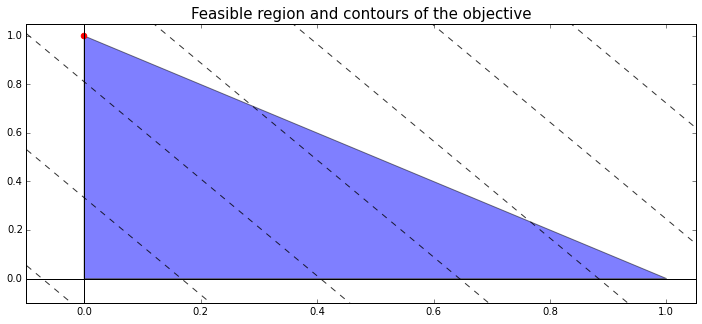

In [29]:
sol = Newton_root(f_LPsmall, J_LPsmall, [0.5,0.5,0,1,1,1,1])
draw_LP_region()
print "F(x) = 0:", np.allclose(f_LPsmall(sol), 0)
plt.scatter(sol[0],sol[1],color="red",s=30)
print "Solution (x's, lambda, mu's):", sol

And here is the problem. We have found a root of F, but it is not the one we were looking for. A glance at the solution tells us why: $\mu_3 = -1$ which is less than 0, a violation of the constraints! 

Interior point methods stay in the feasible region of the constraints $x_i \geq 0, \mu_i \geq 0$ while working to solve $F(x,\lambda,\mu) = 0$. That means we can't just take Newton steps willy-nilly, because eventually a Newton step will cause us to step outside this feasible region.

At this point we can try to scale the Newton step: take as much of it as possible while remaining feasible.

Suppose the current values are $\vec x$ and $\vec \mu$, and let the full Newton step be $\Delta x$ and $\Delta \mu$. We seek a scaling factor $t \leq 1$ such that the minimum value among the new values of $x$ and $\mu$ is $0$:

$$
\text{min}\begin{bmatrix}
x \\
\mu
\end{bmatrix} + \begin{bmatrix} \Delta x \\ \Delta \mu 
\end{bmatrix} = 0
$$

If none of these equations has a solution with $0\leq t \leq 1$, then we can take the full step.


$$ 
t = \min\{1,\frac{-x_i}{\Delta x_i}, \frac{-\mu_i}{\Delta \mu_i} \}
$$

where the two terms dependent on $i$ are understood to range over all $i$, for a total of $2m+1$ terms where $m$ is the number of variables.

So: let us write the linear programming problem (LPP) in general:

$$\begin{equation*}
\begin{aligned}
& \underset{x}{\text{minimize}}
& & c^Tx \\
& \text{subject to}
& & Ax=b \\
& & & x \geq 0 \\
\end{aligned}
\end{equation*}
$$ 

Introduce a $\lambda_i$ for each row of the constraint matrix $A$ and a $\mu_i$ for each constraint $x_i \geq 0$. Then Lagrangian for this problem is 

$$
\mathcal{L}(x,\lambda,\mu) = c^T x - (Ax-b)^T\lambda - x^T \mu
$$

Taking derivatives, we obtain the KKT conditions for this problem:

$$
A^T \lambda + \mu - c^T = 0 \\
Ax = b \\
x_i \mu_i = 0 \\
x_i \geq 0 \\
\mu_i \geq 0 
$$

Let us call the left hand side of the three sets of equalities $F(x,\lambda, \mu)$, a vector-valued function whose root we seek. The Jacobian of $F$ is 

$$
J(x,\lambda,\mu) = \begin{bmatrix}
0 & A^T & I \\
A & 0   & 0 \\
\mu & 0 & x \\
\end{bmatrix}
$$

So the equation we will solve at every Newton step is going to be

$$
J\begin{bmatrix}
\Delta x \\
\Delta\lambda \\
\Delta\mu
\end{bmatrix} = -F.
$$

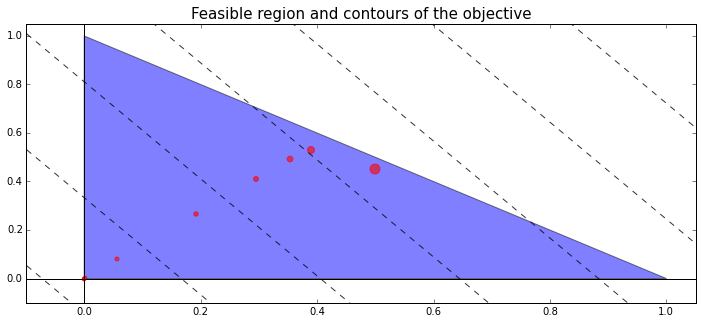

In [30]:
draw_LP_region()
t_sequence = []
def LP_interior_scaled(A, b, c, x_init, maxit=20, eps=1e-6): # min c.x, s.t. Ax=b, all x >= 0
    assert(np.all(x_init >= 0)) # initial solution must be feasible
    assert(np.allclose(np.dot(A,x_init), b)) # initial solution must satisfy Ax=b
    nrows, ncols = A.shape
    assert nrows < ncols # there must be fewer constraints than variables
    pdvars = np.concatenate([x_init, np.ones(nrows + ncols)]) # the vector of all primal and dual vars
    c = c.ravel() # put objective vector c in standard column form
    def unpackvars(p): # given concatenated vector pdvars, returns vectors of x's, lambdas, and mus
        return p[:ncols], p[ncols:ncols+nrows], p[ncols+nrows:]
    for iteration in xrange(maxit):
        xs,lambdas,mus = unpackvars(pdvars) # get vectors of xs, lambdas (equality duals), mus (inequality duals)
        rhs = np.concatenate([np.dot(A.T, lambdas) + mus -c.T, (np.dot(A,xs)-b).T, (xs*mus).T])
        Jac = np.bmat([[np.zeros((ncols,ncols)), A.T, np.eye(ncols)],
                      [A, np.zeros((nrows,nrows)), np.zeros((nrows,ncols))],
                       [np.diag(mus), np.zeros((ncols,1)), np.diag(xs)]])
        # Above, we computed the function-value and Jacobian for the KKT system.
        del_pdvars = np.linalg.solve(Jac, -rhs) # expensive step: solve system of equations Jp = -rhs
        dx,dl,dm = unpackvars(del_pdvars) # get the individual vectors of deltas
        if np.linalg.norm(del_pdvars, ord=inf) < eps: break # convergence??
        ts = np.concatenate([-xs/dx, -mus/dm]) # The amounts by which we can move before becoming negative 
        ts = ts[ts>0] # We will only add positive amounts of pd_vars
        best = min(np.nanmin(ts),1)*0.99 # We are limited by that component that hits 0 first
        t_sequence.append(best)
        plt.scatter(pdvars[0],pdvars[1],s=100./(iteration+1), color='r', alpha=0.6) # draw it!
        pdvars = pdvars + best*del_pdvars # Perform update: take the scaled step
LP_interior_scaled(np.array([[1,1,1]]), np.array(1), np.array([2,1,0]), np.array([0.5,0.45,0.05]))
plt.show()

### The so-called "logarithmic barrier"

To stay feasible, we had to scale each Newton step by an amount $t \leq 1$. How strong was this restriction on our rate of convergence? Let's plot the sequence of $t$'s encountered on the way to solution, in the problem above.

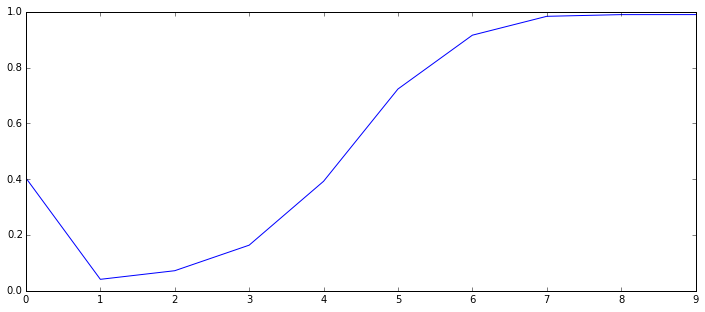

In [31]:
_=plt.plot(t_sequence)

So until we get quite close to the solution, our steps are severely limited by the requirement to stay feasible. One of our constraints is forcing us to step aggressively out of the feasible region. To avoid doing that, we in turn aggressively scale down the amount of that step we actually take.

Knowing this, can we identify which constraint is responsible and fix it? The feasible region is defined by

$$
x_i \geq 0, \; i=1, \dots, n \\
\mu_i \geq 0, \; i=1, \dots, n
$$

But the complementary slackness constraints ask for

$$
x_i \mu_i = 0 \; i = 1, \ldots, n.
$$

To satisfy them, each Newton step reduces the values of $x_i$ and $\mu_i$. 

The key idea is to relax this constraint. Instead of enforcing it at every iteration, we will enforce it gradually. We sacrifice the progress of every constraint toward the minimum, thereby allowing _some_ of them to progress more quickly.

One way to do that is to ask for a reduction in the average value of $x_i \mu_i$ each iteration. Define the _duality measure_ 

$$\eta(\vec x,\vec \mu) = \frac{1}{n}\sum_i{x_i \mu_i} = \frac{x^T\mu}{n}$$

and replace the complentary slackness constraints with

$$
x_i \mu_i = \sigma \eta
$$

where $0 \leq \sigma \leq 1$ is a parameter known as the _centering parameter_ that controls how strictly we drive enforcement. 

Note that $\eta$ in the equation above is understood to be the value of the duality measure at that iteration. We are not asking for $x_i \mu_i = \sigma \eta(x_i, \mu_i)$! 

Our KKT system now looks like 

$$
A^T \lambda + \mu - c^T = 0 \\
Ax = b \\
x_i \mu_i = \sigma \eta \\
x_i \geq 0 \\
\mu_i \geq 0 
$$

where $\eta$ is a constant for that iteration and $\sigma$ is constant for the algorithm. The function that we will set to $0$ for the equality constraints is

$$
F(x,\lambda,\mu) = \begin{bmatrix}
A^T \lambda + \mu - c^T \\
Ax-b \\
XSe - \sigma \eta
\end{bmatrix}
$$

and the Jacobian is unchanged.

7 iterations


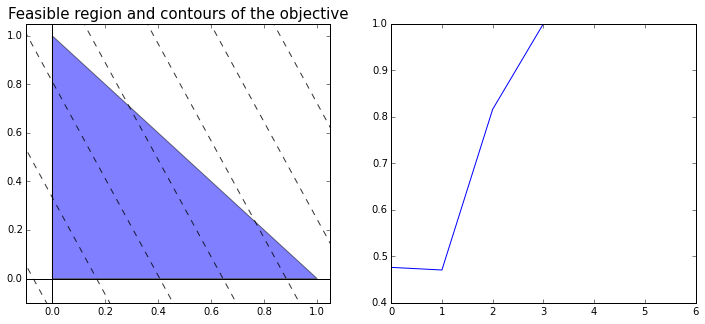

In [32]:
plt.subplot(1,2,1)
draw_LP_region()
t_sequence = []
def LP_interior_centering(A, b, c, x_init, lambda_init = None, mu_init=None,
                          maxit=20, eps=1e-6, sigma=0.2): # min c.x, s.t. Ax=b, all x >= 0
    assert(np.all(x_init >= 0)) # initial solution must be feasible
    assert(np.allclose(np.dot(A,x_init), b)) # initial solution must satisfy Ax=b
    nrows, ncols = A.shape
    assert nrows < ncols # there must be fewer constraints than variables
    if lambda_init is None: lambda_init = np.ones(nrows)
    if mu_init is None: mu_init = np.ones(ncols)
    pdvars = np.concatenate([x_init, lambda_init, mu_init]) # the vector of all primal and dual vars
    c = c.ravel() # put objective vector c in standard column form
    def unpackvars(p): # given concatenated vector pdvars, returns vectors of x's, lambdas, and mus
        return p[:ncols], p[ncols:ncols+nrows], p[ncols+nrows:]
    for iteration in xrange(maxit):
        xs,lambdas,mus = unpackvars(pdvars) # get vectors of xs, lambdas (equality duals), mus (inequality duals)
        duality_measure = xs.dot(mus)/ncols
        rhs = np.concatenate([np.dot(A.T, lambdas) + mus -c.T, 
                              (np.dot(A,xs)-b).T, 
                              (xs*mus).T - sigma*duality_measure])
        Jac = np.bmat([[np.zeros((ncols,ncols)), A.T, np.eye(ncols)],
                      [A, np.zeros((nrows,nrows)), np.zeros((nrows,ncols))],
                       [np.diag(mus), np.zeros((ncols,nrows)), np.diag(xs)]])
        # Above, we computed the function-value and Jacobian for the KKT system.
        del_pdvars = np.linalg.solve(Jac, -rhs) # expensive step: solve system of equations Jp = -rhs
        dx,dl,dm = unpackvars(del_pdvars) # get the individual vectors of deltas
        if np.linalg.norm(del_pdvars, ord=inf) < eps: break # convergence??
        ts = np.concatenate([-xs/dx, -mus/dm]) # The amounts by which we can move before becoming negative 
        ts = ts[ts>0] # We will only add positive amounts of pd_vars
        best = min(np.nanmin(ts),1) # We are limited by that component that hits 0 first
        t_sequence.append(best)
        #plt.scatter(pdvars[0],pdvars[1],s=100./(iteration+1), color='r', alpha=0.6) # draw it!
        pdvars = pdvars + best*del_pdvars # Perform update: take the scaled step
    print iteration, "iterations"
    return unpackvars(pdvars)[0]
LP_interior_centering(np.array([[1,1,1]]), np.array(1), np.array([2,1,0]), np.array([0.4,0.4,0.2]),
                     sigma=0.1)
plt.subplot(1,2,2)
plt.plot(t_sequence)
plt.show()

In [33]:
t_sequence = []
def indep(XX,rhs,tol=1e-9):
    Q,R = np.linalg.qr(XX.T)
    ind = np.where(np.abs(R.diagonal()) > tol)
    return XX.T[:,ind].T.reshape((-1,XX.shape[1])), rhs[ind]
def LP_interior_centering(AA, bb, c, x_init = None, lambda_init = None, mu_init=None,
                          maxit=100, eps=1e-6, sigma=0.2): # min c.x, s.t. Ax=b, all x >= 0
    A,b=indep(AA,bb)
    nrows, ncols = A.shape
    if x_init is None:
        x_init = np.ones(ncols)
    assert(np.all(x_init >= 0)) # initial solution must be feasible
    assert nrows < ncols # there must be fewer constraints than variables
    if lambda_init is None: lambda_init = np.ones(nrows)
    if mu_init is None: mu_init = np.ones(ncols)
    pdvars = np.concatenate([x_init, lambda_init, mu_init]) # the vector of all primal and dual vars
    c = c.ravel() # put objective vector c in standard column form
    def unpackvars(p): # given concatenated vector pdvars, returns vectors of x's, lambdas, and mus
        return p[:ncols], p[ncols:ncols+nrows], p[ncols+nrows:]
    soltime = 0
    Z1, E1, Z2, Z3 = np.zeros((ncols,ncols)), np.eye(ncols), np.zeros((nrows,nrows)), np.zeros((nrows,ncols))
    Z4 = Z3.T
    for iteration in xrange(maxit):
        xs,lambdas,mus = unpackvars(pdvars) # get vectors of xs, lambdas (equality duals), mus (inequality duals)
        duality_measure = xs.dot(mus)/ncols
        rhs = np.concatenate([np.dot(A.T, lambdas) + mus -c.T, 
                              (np.dot(A,xs)-b).T, 
                              (xs*mus).T - sigma*duality_measure])
        Jac = np.bmat([[Z1, A.T, E1],
                      [A, Z2, Z3],
                    [np.diag(mus), Z4, np.diag(xs)]])
        # Above, we computed the function-value and Jacobian for the KKT system.
        starttime = time.clock()
        #del_pdvars = scipy.linalg.lstsq(Jac, -rhs)[0] # expensive step: solve system of equations Jp = -rhs
        del_pdvars = scipy.linalg.solve(Jac, -rhs) # expensive step: solve system of equations Jp = -rhs
        soltime += (time.clock() - starttime)
        dx,dl,dm = unpackvars(del_pdvars) # get the individual vectors of deltas
        if np.linalg.norm(del_pdvars, ord=1)/ncols < eps: break # convergence??
        ts = np.concatenate([-xs/dx, -mus/dm]) # The amounts by which we can move before becoming negative 
        ts = ts[ts>0] # We will only add positive amounts of pd_vars
        best = min(np.nanmin(ts),1) # We are limited by that component that hits 0 first
        t_sequence.append(best)
        #plt.scatter(pdvars[0],pdvars[1],s=100./(iteration+1), color='r', alpha=0.6) # draw it!
        pdvars = pdvars + best*del_pdvars # Perform update: take the scaled step
    #print iteration, "iterations in", soltime
    answer = unpackvars(pdvars)[0]
    answer[np.abs(answer)<eps]=0
    return answer

def random_problem(mm, nn):
    A = np.random.randn(mm,mm+nn)
    x = np.concatenate([4+np.random.rand(mm), 1+np.random.rand(nn)])
    mu = np.concatenate([1+np.random.rand(mm), 1+np.random.rand(nn)])
    lambdas = np.random.randn(mm)
    c = np.dot(A.T, lambdas)  + mu
    b = np.dot(A,x)
    return A,b,c

interior_times, simplex_times = [],[]
for testit in xrange(25):
    mm,nn = 10,5 # num constraints, num free vars
    A,b,c = random_problem(mm,nn)

    start_total = time.clock()
    answer = LP_interior_centering(A,b,c,sigma=0.1,eps=1e-6)
    end_total = time.clock() - start_total

    start_linprog = time.clock()
    optans = optimize.linprog(c, A_eq=A, b_eq=b)
    end_linprog = time.clock() - start_linprog
    #print np.max(np.log(np.abs(optans.x-answer))/np.log(10))
    
    if end_total < end_linprog or (not optans.success): winner = "IPM"
    else: winner = "SIM"
    print winner, optans.nit, "simplex iterations in", end_linprog, "; interior:", end_total, optans.success
    interior_times.append(end_total)
    simplex_times.append(end_linprog)
    if not (np.allclose(optans.x,answer,atol=1e-5*2) or (not optans.success)):
        print answer
        print optans.x
        print np.log(np.abs(answer-optans.x))/np.log(10)
        assert False
print "IPM mean", np.mean(interior_times), "+-", np.std(interior_times)
print "SIM mean", np.mean(simplex_times), "+=", np.std(simplex_times)

IPM 13 simplex iterations in 0.01333 ; interior: 0.011502 True
IPM 13 simplex iterations in 0.013594 ; interior: 0.006654 True
IPM 12 simplex iterations in 0.005961 ; interior: 0.005936 True
IPM 12 simplex iterations in 0.006697 ; interior: 0.004621 True
IPM 11 simplex iterations in 0.006023 ; interior: 0.003928 True
IPM 15 simplex iterations in 0.00827 ; interior: 0.007705 True
SIM 12 simplex iterations in 0.007834 ; interior: 0.007935 True
IPM 13 simplex iterations in 0.006529 ; interior: 0.005567 True
IPM 15 simplex iterations in 0.007641 ; interior: 0.004901 True
IPM 13 simplex iterations in 0.008169 ; interior: 0.005072 True
IPM 15 simplex iterations in 0.011659 ; interior: 0.005965 True
IPM 13 simplex iterations in 0.007333 ; interior: 0.004885 True
IPM 13 simplex iterations in 0.006328 ; interior: 0.004957 True
IPM 14 simplex iterations in 0.007653 ; interior: 0.006049 True
IPM 16 simplex iterations in 0.009722 ; interior: 0.007166 True
IPM 13 simplex iterations in 0.007479 ; in

In [34]:
mm,nn=10,20
AA,bb,cc = random_problem(mm,nn)
dAA = np.vstack([2*AA[0,:],AA,3*AA[1,:]])
dbb = np.concatenate([[2*bb[0]], bb, [3*bb[1]]])
print optimize.linprog(cc,A_eq=AA,b_eq=bb).x
print optimize.linprog(cc,A_eq=dAA,b_eq=dbb).x
print LP_interior_centering(AA,bb,cc,sigma=0.1,eps=1e-6)
print LP_interior_centering(dAA,dbb,cc,sigma=0.1,eps=1e-6)


[ 0.          6.61466067  7.63698633  0.          0.          1.90270921
  5.83823233  0.          0.58941447  0.          0.          0.          0.
  0.          6.14783722  0.          0.          0.          0.          0.
  0.          0.          0.          1.9368752   0.          5.75982501
  8.08748424  0.          0.          6.39669979]
[  0.           5.43956938   3.73584757   0.           0.           0.
  10.17458776   1.81488308   2.01030919   0.           0.           0.           0.
   0.           6.32441482   2.05201909   0.           0.           0.53412858
   0.           0.           0.           0.           0.           0.
   5.25768391   8.21379523   0.           0.           3.94992662]
[ 0.          6.6146606   7.63698588  0.          0.          1.90270905
  5.83823254  0.          0.58941452  0.          0.          0.          0.
  0.          6.14783723  0.          0.          0.          0.          0.
  0.          0.          0.          1.93687485  0

### Conclusions from the test

Surprisingly, this naive interior point implementation is competitive with ``scipy.optimize.linprog``, a result that makes me doubt the quality of that implementation.

Simplex is competitive and often performs better on small problems with a lot of free variables ie. problems where there are a lot more columns $n$ than rows $m$.

The interior point method does better on highly constrained problems. 

Moreover, it takes between 15 and 25 iterations to converge no matter the size or shape of problem. What changes is the cost of each iteration. The great majority of the time in the interior point method is spent solving a big linear system each iteration. 

But that's a step that can be parallelized.

As problems get bigger ($n+m \geq 200$) simplex often fails to find a feasible solution. Aha! Maybe this explains what we're seeing. Remember that we helpfully give the interior point method a feasible solution at the beginning.

Perhaps the main difficulty in these random problems is _finding_ a feasible solution in the first place. In highly constrained problems this advantage gets more pronounced.

### Fair Comparison

Instead of giving the interior point method a starting solution, we let it generate its own starting solution by the trivial method of starting at all ones.

Now we have a fair comparison of the two methods: we give each one the exact same input of $A$, $b$ and $c$. Even now the interior point method outperforms simplex conclusively, except (again) on problems with a large number of free variables ie. $n-m$ is large.

The interior point method always converges to right solution, while the simplex method has trouble finding feasible starting points as the problem size increases. On highly constrained problems the interior point method always outperforms simplex, and on relatively unconstrained problems it sometimes outperforms simplex.

The real surprise is that on tiny problems of less than 10 rows and columns, the interior point method _still_ regularly beats simplex!

For problems with $m+n \geq 200$ it's the only choice.

Wow! This is a powerful technique. Also, the ``scipy`` simplex solver must be really badly implemented.

In [45]:
J = np.random.random((3,3))

In [56]:
Q,R = scipy.linalg.qr(J)
# Now we have a CHOLESKY decomposition of J^T J
Q1,R1 = scipy.linalg.qr(np.bmat([[J], [2*np.eye(3)]]))
B = J.T.dot(J) + 4*np.eye(3)
print B
print R1.T.dot(R1)

[[ 4.65767576  0.89091018  0.74455118]
 [ 0.89091018  5.59340027  1.45938108]
 [ 0.74455118  1.45938108  5.40412888]]
[[ 4.65767576  0.89091018  0.74455118]
 [ 0.89091018  5.59340027  1.45938108]
 [ 0.74455118  1.45938108  5.40412888]]


In [133]:
def random_symmetric(nn=None):
    if nn is None: nn = np.random.randint(10)
    A = np.random.random((nn,nn))
    return A+A.T
B = random_symmetric(3)
q,e = np.random.random(3), np.random.random()

In [138]:
d,U = scipy.linalg.eig(B)
D,DD = np.diag(np.sqrt(d)), np.diag(d)
print U
print U.T 
print U.dot(U.T)
print U.T.dot(U)
print q.T.dot(B.dot(q)), e
print "OBJECTIVE", (q.T.dot(B.dot(q))-e)**2
print np.dot(q, np.dot(B,q))


[[ 0.60826193  0.78582397  0.11179496]
 [ 0.53571624 -0.30251353 -0.7883487 ]
 [ 0.58568382 -0.53941288  0.60498612]]
[[ 0.60826193  0.53571624  0.58568382]
 [ 0.78582397 -0.30251353 -0.53941288]
 [ 0.11179496 -0.7883487   0.60498612]]
[[  1.00000000e+00  -1.80411242e-16   5.55111512e-17]
 [ -1.80411242e-16   1.00000000e+00   5.55111512e-17]
 [  5.55111512e-17   5.55111512e-17   1.00000000e+00]]
[[  1.00000000e+00   1.11022302e-16   0.00000000e+00]
 [  1.11022302e-16   1.00000000e+00   2.22044605e-16]
 [  0.00000000e+00   2.22044605e-16   1.00000000e+00]]
3.87910329471 0.83829419946
OBJECTIVE 9.24651995374
3.87910329471


In [135]:
a = D.dot(U.T.dot(q))
print a.dot(a)
b = D.dot(q)
print b.dot(b)
print a,b

(3.87910329471+0j)
(1.20800043252+0j)
[ 1.96335278+0.j          0.00000000+0.04519941j -0.16245656+0.j        ] [ 1.22369641+0.j          0.00000000+0.63022079j  0.32824651+0.j        ]


In [141]:
assert np.allclose(U.T.dot(U), np.eye(3))
a = U.dot(q)
assert np.allclose(a.dot(a), q.dot(q))
F = np.dot(D, U.T)
g = F.dot(q)
print g.dot(g)**2 - 2*e*g.dot(g) + e**2

(9.24651995374+0j)


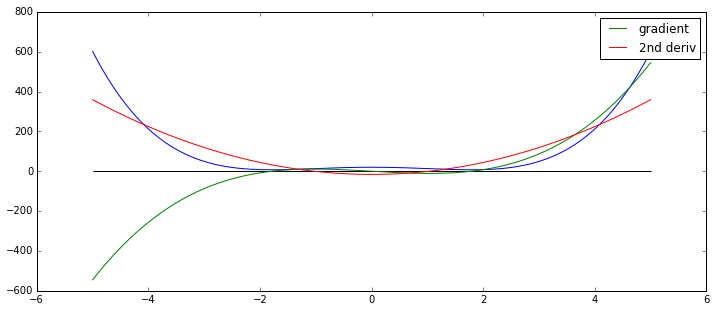

In [163]:
AA,ee = 0.5, 4
BB,dd = 1, 2
def conv1(x, A, e):
    return (A*x**2 - e)**2
def g_conv1(x, A, e):
    return 2*(A*x**2 - e)*2*x*A
def H_conv1(x, A, e):
    return 4*A*(3*A*x**2 - e)
def conv2(x, A, e, B, d):
    return conv1(x,A,e) + conv1(x,B,d)
def g_conv2(x, A, e, B, d):
    return g_conv1(x,A,e) + g_conv1(x,B,d)
def H_conv2(x, A, e, B, d):
    return H_conv1(x,A,e) + H_conv1(x,B,d)
xs = np.linspace(-5,5,1000)
plt.plot(xs, conv2(xs, AA, ee, BB, dd))
plt.plot(xs, g_conv2(xs, AA, ee, BB, dd), label='gradient')
plt.plot(xs, H_conv2(xs, AA, ee, BB, dd), label='2nd deriv')
plt.hlines(0,-5,5)
plt.legend()

In [502]:
Msize = 4
Ms = [M.T+M for M in [np.random.random((Msize,Msize)) for ii in range(10)]]
ds =[1]*len(Ms)
qs = np.random.random(Msize)

In [504]:
def ese_obj(qs):
    return sum([(qs.T.dot(M.dot(qs)) - d)**2 for (M,d) in zip(Ms,ds)])
def ese_grad(qs):
    return optimize.approx_fprime(qs, ese_obj, 1e-5)
def ese_Hess(qs):
    return optimize.slsqp.approx_jacobian(qs, ese_grad, 1e-4)
def exact_ese_grad(qs):
    answer = np.zeros_like(qs)
    for A,d in zip(Ms,ds):
        en = qs.T.dot(A.dot(qs))
        answer += (en-d)*A.dot(qs)
    return 4*answer
def exact_ese_Hess(qs):
    answer = np.zeros((qs.shape[0], qs.shape[0]))
    for A,d in zip(Ms,ds):
        Aq = A.dot(qs)
        en = qs.T.dot(A.dot(qs))
        answer += 2*np.outer(Aq, Aq) + (en-d)*A
    return 4*answer
print ese_obj(qs), ese_grad(qs) #, ese_Hess(qs)

261.234613111 [ 505.75226546  489.98835265  554.19127346  429.42305263]


In [509]:
q_star = Newton_root(exact_ese_grad, exact_ese_Hess, qs, verbose=True,eps=1e-6)
print q_star, ese_obj(q_star)
print exact_ese_grad(q_star)
#print ese_Hess(q_star)
print ese_obj(qs) > ese_obj(q_star)

Iterations: 8
[ 0.35170093  0.22031236  0.23465697  0.19654616] 0.0598636072979
[  1.05045819e-09   1.32276587e-09   1.41240067e-09   5.15044563e-10]
True
